## This notebook is for pre-processing liveability factor data

### 1. Setting up the coding environment (Nene)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Function to save cleaned dataframe

def save_data(dataframe, dest: str, name: str):
    file = os.path.join(dest, name)  # dest/name

    # If the file is not existing...
    if not os.path.isfile(file):
        print(f"{file} not found, saving...")
        path = os.path.split(dest)  # dest1, dest2

        # Make sure the destination file exits
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        # Save the file
        dataframe.to_csv(file, index=False)

        print("\tDone saving.")

    else:
        print(f"Found {file} locally, done!")

    return

### 2. Housing data (Nene)

In [ ]:
# Reading in the data

file = os.path.join('data', 'raw', 'housing_data_ward.csv')
cols = ['Ward name', 'New code', 'Median House Price (£) - 2014']


df_housing = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')
df_housing.info()

NameError: ignored

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving housing_data_ward.csv to housing_data_ward.csv


In [ ]:
import io
df_housing = pd.read_csv(io.BytesIO(uploaded['housing_data_ward.csv']))

UnicodeDecodeError: ignored

In [ ]:
# Renaming columns
df_housing.rename(columns={"Ward name": "ward_name", 
                           "New code": "new_code",
                           "Median House Price (£) - 2014": "median_house"},
                  inplace=True)

<AxesSubplot:ylabel='Frequency'>

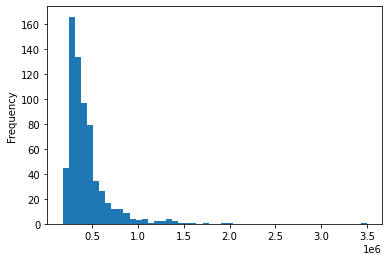

In [ ]:
df_housing.median_house.plot.hist(bins=50)

In [ ]:
# Take logarithm
df_housing["median_house_log"]= np.log(df_housing.median_house)

<AxesSubplot:ylabel='Frequency'>

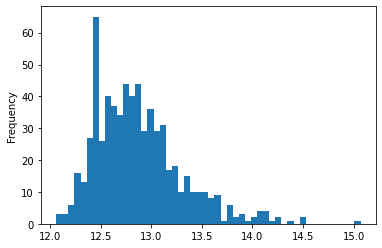

In [ ]:
df_housing.median_house_log.plot.hist(bins=50)

In [ ]:
# Standard deviation of the new distribution:
df_housing.median_house_log.std()

0.4315805146349902

In [ ]:
# Mean of the new distribution:
df_housing.median_house_log.mean()

12.86974784026538

### 4. Combining and outputing data (Richy)

In [26]:
from google.colab import files
uploaded = files.upload()

Saving london-ward-well-being-probability-scores.xls to london-ward-well-being-probability-scores (1).xls


In [27]:
import io
livability_no_housing = pd.read_excel(io.BytesIO(uploaded['london-ward-well-being-probability-scores.xlsx']))

KeyError: ignored

In [ ]:
# Renaming columns
livability_no_housing.rename(columns={"New ward code": "new_ward_code",
                                      "Unemployment rate 2013": "Unemployment_rate_2013",
                                      "Crime rate - 2013": "Crime_rate_2013",
                                      "Life Expectancy 2009-13": "Life_Expectancy_2009-13",
                                      "GCSE point scores - 2013": "GCSE_point_scores_2013",
                                      "Public Transport Accessibility - 2013": "Public_Transport_Accessibility_2013",
                                      "Homes with access to open space & nature, and % greenspace - 2013": "Homes_with access_to_open_space_nature"},
                  inplace=True)

In [ ]:
livability_no_housing

,Old_Ward_Code,New_ward_code,Ward_name,Life Expectancy,Crime rate - Index,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Average Capped GCSE and Equivalent Point Score Per Pupil
0,NaN,NaN,NaN,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
1,00AA,E09000001,City of London,23.661861,17.205862,12.784338,11.095605,16.026485
2,00ABFX,E05000026,Abbey,4.251859,-18.441350,7.439813,4.309807,1.417979
3,00ABFY,E05000027,Alibon,-9.035117,-9.218119,-10.618268,-12.228139,-11.527627
4,00ABFZ,E05000028,Becontree,-7.975613,-13.060348,-7.846086,-10.413797,-7.727404
...,...,...,...,...,...,...,...,...
655,00BF,E09000029,SUTTON,5.351062,1.193134,2.210753,1.995546,5.012325
656,00BG,E09000030,TOWER HAMLETS,-6.477760,-1.357916,-11.551391,-11.214244,-8.104173
657,00BH,E09000031,WALTHAM FOREST,1.462313,-11.270727,-3.888160,-2.383817,0.678782
658,00BJ,E09000032,WANDSWORTH,0.810493,-7.482790,-2.479537,-2.712316,0.250660


In [ ]:
# merge 
all_data = pd.merge(livability_no_housing, df_housing, left_on='new_ward_code', right_on='new_code', how='inner')
all_data.sample(3, random_state=42)[['new_ward_code','Ward','Borough','msoa11hclnm', 'Unemployment_rate_2013', 'Crime_rate_2013', 'Life_Expectancy_2009-13', 'GCSE_point_scores_2013', 'Public_Transport_Accessibility_2013', 'Homes_with access_to_open_space_nature', 'Crime rate - 2013": "Crime_rate_2013'    ]]

In [ ]:
# standard devation of each column
all_data['Unemployment_rate_2013'].std()
all_data['Crime_rate_2013'].std()
all_data['Life_Expectancy_2009-13'].std()
all_data['GCSE_point_scores_2013'].std()
all_data['Public_Transport_Accessibility_2013'].std()
all_data['Homes_with access_to_open_space_nature'].std()
all_data['median_house'].std()

In [ ]:
all_data[["Unemployment_rate_2013", "Crime_rate_2013", "Life_Expectancy_2009-13", "GCSE_point_scores_2013", "Public_Transport_Accessibility_2013", "Homes_with access_to_open_space_nature", "median_house"   ]].std()

In [ ]:
# mean of each column
all_data['Unemployment_rate_2013'].mean()
all_data['Crime_rate_2013'].mean()
all_data['Life_Expectancy_2009-13'].mean()
all_data['GCSE_point_scores_2013'].mean()
all_data['Public_Transport_Accessibility_2013'].mean()
all_data['Homes_with access_to_open_space_nature'].mean()
all_data['median_house'].mean()

In [ ]:
all_data[["Unemployment_rate_2013", "Crime_rate_2013", "Life_Expectancy_2009-13", "GCSE_point_scores_2013", "Public_Transport_Accessibility_2013", "Homes_with access_to_open_space_nature", "median_house"   ]].mean()

In [ ]:
# print the skew
print(all_data['Unemployment_rate_2013'].skew())
print(all_data['Crime_rate_2013'].skew())
print(all_data['Life_Expectancy_2009-13'].skew())
print(all_data['GCSE_point_scores_2013'.skew())
print(all_data['Public_Transport_Accessibility_2013'].skew())
print(all_data['Homes_with access_to_open_space_nature'].skew())
print(all_data['median_house'].skew())


In [ ]:
all_data[["Unemployment_rate_2013", "Crime_rate_2013", "Life_Expectancy_2009-13", "GCSE_point_scores_2013", "Public_Transport_Accessibility_2013", "Homes_with access_to_open_space_nature", "median_house"   ]].skew()

In [ ]:
all_data.Unemployment_rate_2013.plot.hist(bins=50)

In [ ]:
all_data.Crime_rate_2013.plot.hist(bins=50)

In [ ]:
all_data.Life_Expectancy_2009-13.plot.hist(bins=50)

In [ ]:
all_data.GCSE_point_scores_2013.plot.hist(bins=50)

In [ ]:
all_data.Public_Transport_Accessibility_2013.plot.hist(bins=50)

In [ ]:
all_data.CHomes_with access_to_open_space_nature.plot.hist(bins=50)

In [ ]:
all_data.median_house.plot.hist(bins=50)

## Work on Unemployment data - can be scrapped?

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving unemploymentdata.xlsx to unemploymentdata.xlsx


In [ ]:
import io
unemployment_data = pd.read_excel(io.BytesIO(uploaded['unemploymentdata.xlsx']))

In [ ]:
unemployment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Old_Ward_Code           659 non-null    object 
 1   New_ward_code           659 non-null    object 
 2   Ward                    657 non-null    object 
 3   Borough                 659 non-null    object 
 4   Unemployment_rate_2013  659 non-null    float64
 5   Unnamed: 5              659 non-null    float64
dtypes: float64(2), object(4)
memory usage: 31.1+ KB


In [ ]:
unemployment_data.Unemployment_rate_2013.std()

3.308749395059806

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
remove_outlier(unemployment_data, "Unemployment_rate_2013")

,Old_Ward_Code,New_ward_code,Ward,Borough,Unemployment_rate_2013,Unnamed: 5
1,00AA,E09000001,City of London,City of London,2.234870,38.014542
2,00ABFX,E05000026,Abbey,Barking and Dagenham,8.905805,151.485376
3,00ABFY,E05000027,Alibon,Barking and Dagenham,10.202542,173.542522
4,00ABFZ,E05000028,Becontree,Barking and Dagenham,9.930396,168.913398
5,00ABGA,E05000029,Chadwell Heath,Barking and Dagenham,8.591037,146.131252
...,...,...,...,...,...,...
655,00BF,E09000029,SUTTON,Sutton,3.459205,58.840156
656,00BG,E09000030,TOWER HAMLETS,Tower Hamlets,9.172354,156.019295
657,00BH,E09000031,WALTHAM FOREST,Waltham Forest,8.393529,142.771701
658,00BJ,E09000032,WANDSWORTH,Wandsworth,3.663954,62.322882


In [ ]:
unemployment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Old_Ward_Code           659 non-null    object 
 1   New_ward_code           659 non-null    object 
 2   Ward                    657 non-null    object 
 3   Borough                 659 non-null    object 
 4   Unemployment_rate_2013  659 non-null    float64
 5   Unnamed: 5              659 non-null    float64
dtypes: float64(2), object(4)
memory usage: 31.1+ KB


In [ ]:
unemployment_data.Unemployment_rate_2013.std()

3.308749395059806

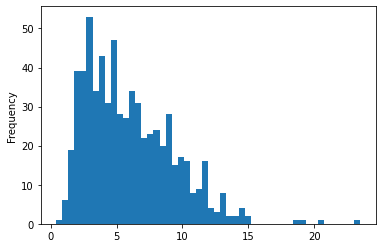

In [ ]:
unemployment_data.Unemployment_rate_2013.plot.hist(bins=50)

In [ ]:
unemployment_data["Unemployment_rate_2013_log"]= np.log(unemployment_data.Unemployment_rate_2013)

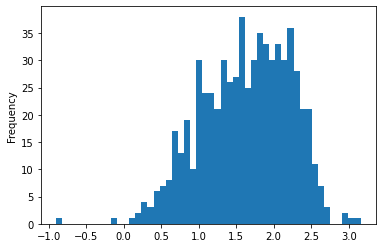

In [ ]:
unemployment_data.Unemployment_rate_2013_log.plot.hist(bins=50)

In [ ]:
unemployment_data.Unemployment_rate_2013_log.std()

0.58789867291056

In [ ]:
# Saving the combined dataframe into csv
'''
dest = os.path.join("data", "clean")
name = "df_data_final.csv"

save_data(df_combined, dest, name)
'''

### 

In [ ]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]